In [1]:
import itertools
import logging
import warnings

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_gbq 

from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
#from pandas.tseries.offsets import DateOffset

DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"

warnings.filterwarnings("ignore")
logger = logging.getLogger()
#logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.ERROR)


/Users/evan/.pyenv/versions/3.11.5/envs/ds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def query_ticker_data():
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_history`
        ORDER BY date
    """
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df

In [3]:
all = query_ticker_data().set_index('date')

In [4]:
apple = all[all['ticker'] == 'AAPL']
netflix = all[all['ticker'] == 'NFLX']
microsoft = all[all['ticker'] == 'MSFT']
amazon = all[all['ticker'] == 'AMZN']
alphabet = all[all['ticker'] == 'GOOGL']
coke = all[all['ticker'] == 'KO']

In [5]:
apple.name = "Apple"
netflix.name = "Netflix"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"
coke.name = "Coca-Cola Co"

In [6]:
TARGET_DF = coke

In [7]:
vwap = TARGET_DF['volume_weighted_average_price']

In [8]:
TARGET_DF['simple_rtn'] = vwap.pct_change()
TARGET_DF['log_rtn'] = np.log(vwap/vwap.shift(1))

[Text(0, 0.5, 'Simple returns (%)')]

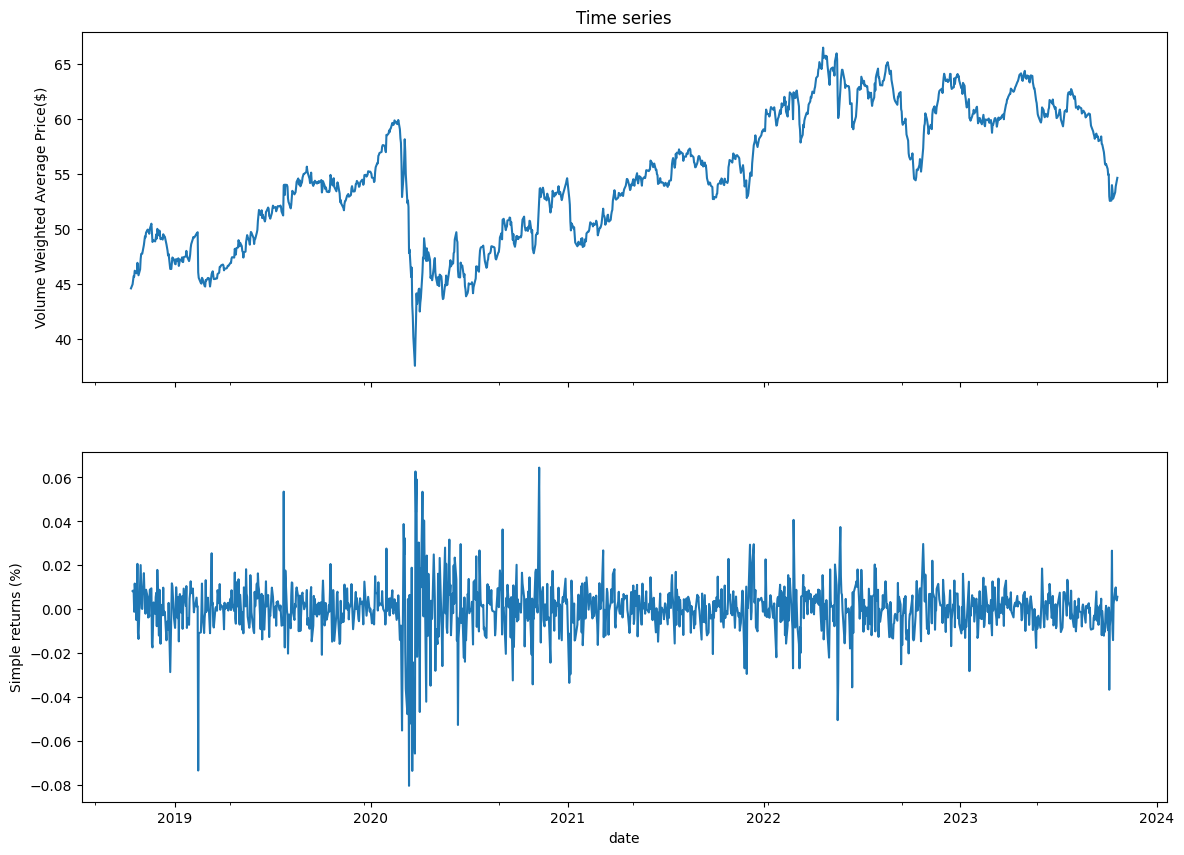

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
vwap.plot(ax=ax[0])
ax[0].set(title = 'Time series', ylabel = 'Volume Weighted Average Price($)')
TARGET_DF.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')

In [10]:
hist = TARGET_DF[['volume_weighted_average_price']]
hist.reset_index(level=0, inplace=True)
hist = hist.rename({'date': 'ds', 'volume_weighted_average_price': 'y'}, axis='columns')

In [11]:
param_grid = { 
    "daily_seasonality": [False],
    "weekly_seasonality": [False],
    "yearly_seasonality": [False, True],
    "growth": ["linear"],
    "seasonality_mode": ["additive", "multiplicative"],    
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    #m= m.add_seasonality(name="quarterly", period=63, fourier_order=10)
    #m.add_country_holidays("US")
    m = m.fit(hist)  # Fit model with given params
    df_cv = cross_validation(m, initial='1095 days', period='63 days', horizon = '252 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results

12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing
12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing
12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] done processing
12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] done processing
12:31:03 - cmdstanpy - INFO - Chain [1] done processing
12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] done processing
12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] done processing
12:31:03 - cmdstanpy - INFO - Chain [1] done processing
12:31:03 - cmdstanpy - INFO - Chain [1]

,daily_seasonality,weekly_seasonality,yearly_seasonality,growth,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,rmse
0,False,False,False,linear,additive,0.001,0.01,4.152059
1,False,False,False,linear,additive,0.001,0.10,4.152059
2,False,False,False,linear,additive,0.001,1.00,4.152059
3,False,False,False,linear,additive,0.001,10.00,4.152059
4,False,False,False,linear,additive,0.010,0.01,4.827778
...,...,...,...,...,...,...,...,...
59,False,False,True,linear,multiplicative,0.100,10.00,5.915918
60,False,False,True,linear,multiplicative,0.500,0.01,5.523076
61,False,False,True,linear,multiplicative,0.500,0.10,6.105379
62,False,False,True,linear,multiplicative,0.500,1.00,6.191994


In [12]:
# Python
best_params = all_params[np.argmin(rmses)]
best_params

{'daily_seasonality': False,
 'weekly_seasonality': False,
 'yearly_seasonality': False,
 'growth': 'linear',
 'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 0.01}

12:33:40 - cmdstanpy - INFO - Chain [1] start processing
12:33:40 - cmdstanpy - INFO - Chain [1] done processing


Predicted Data
             ds       yhat  yhat_lower  yhat_upper
1260 2023-10-17  62.143651   57.316172   66.958818
1261 2023-10-18  62.151520   57.184975   66.775692
1262 2023-10-19  62.159389   57.747217   67.130326
1263 2023-10-20  62.167258   57.503572   66.858607
1264 2023-10-23  62.190865   57.261263   67.234688
1265 2023-10-24  62.198734   56.890450   66.968183
1266 2023-10-25  62.206603   57.757508   67.013524
1267 2023-10-26  62.214472   57.374718   67.167170
1268 2023-10-27  62.222341   57.536755   66.938614
1269 2023-10-30  62.245948   57.259775   67.040692


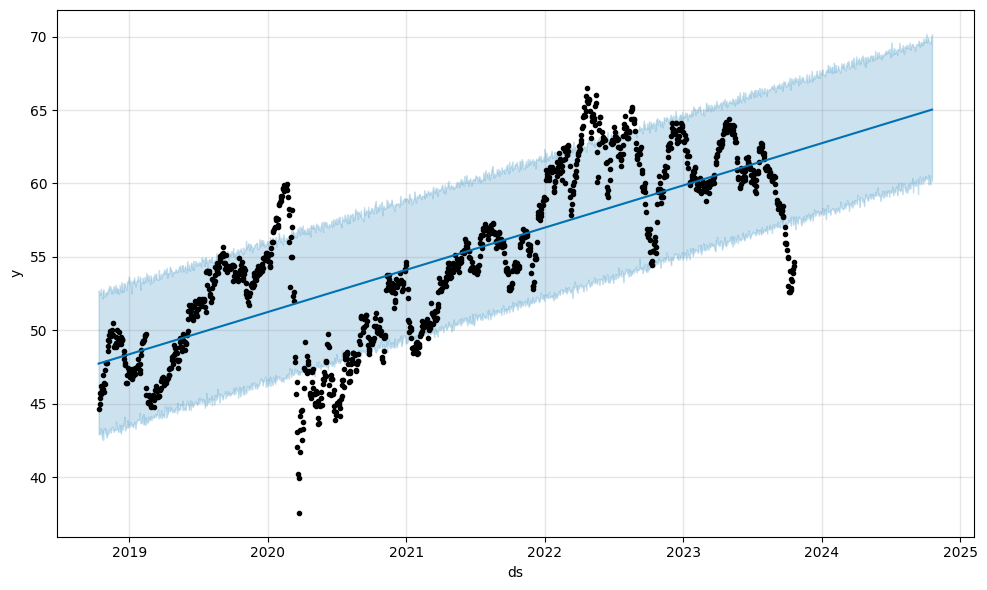

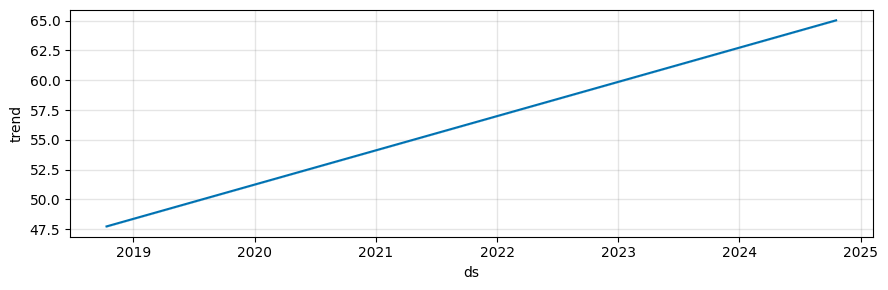

In [13]:
"""
param ={
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "yearly_seasonality": True,
    "growth": "linear",
    "seasonality_mode": "additive",
    'changepoint_prior_scale': 0.01, 
    'seasonality_prior_scale': 10.0
}
"""

m = Prophet(**best_params)
#m= m.add_seasonality(name="monthly", period=30, fourier_order=10)
#m= m.add_seasonality(name="quarterly", period=63, fourier_order=10)
#m.add_country_holidays("US")
m.fit(hist)
future = m.make_future_dataframe(periods=365, freq='D')
future = future[future['ds'].dt.dayofweek < 5]
forecast = m.predict(future)
print("Predicted Data")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[1260:1270])
figure1 = m.plot(forecast)
figure2 = m.plot_components(forecast)

#plot_plotly(m, forecast, figsize=(1000,600)) # 
#plot_components_plotly(m, forecast, figsize=(1000,600))

In [14]:
df_cv = cross_validation(m, initial='1095 days', period='90 days', horizon = '365 days', parallel="processes")

12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing
12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing
12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,18.804337,4.336397,3.661475,0.058706,0.059285,0.061079,0.6480
1,37 days,18.930649,4.350937,3.679240,0.058973,0.059624,0.061385,0.6400
2,38 days,18.845270,4.341114,3.685021,0.059070,0.058198,0.061481,0.6320
3,39 days,18.614683,4.314474,3.667676,0.058812,0.058198,0.061195,0.6256
4,40 days,18.494256,4.300495,3.658814,0.058653,0.058198,0.061036,0.6160
...,...,...,...,...,...,...,...,...
325,361 days,17.922748,4.233527,3.360916,0.057495,0.043242,0.056149,0.7420
326,362 days,18.387897,4.288111,3.395028,0.058193,0.043242,0.056733,0.7408
327,363 days,18.903437,4.347808,3.436894,0.058995,0.043242,0.057443,0.7380
328,364 days,19.276204,4.390467,3.452850,0.059394,0.043242,0.057748,0.7360


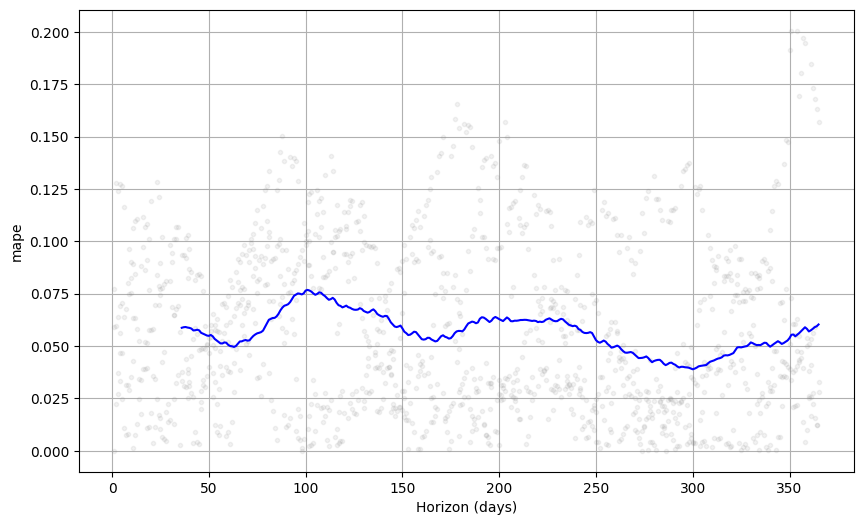

In [16]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [17]:
duckdb.sql("select cutoff, count(*) from df_cv group by 1 order by 1").df()

,cutoff,count_star()
0,2021-10-25,252
1,2022-01-23,251
2,2022-04-23,250
3,2022-07-22,250
4,2022-10-20,251


In [18]:
df_cv[df_cv.cutoff=="2022-10-20"]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
1003,2022-10-21,59.998394,55.131699,64.861432,55.7032,2022-10-20
1004,2022-10-24,60.025167,55.013502,64.968253,57.3595,2022-10-20
1005,2022-10-25,60.034091,55.115244,64.737326,58.5743,2022-10-20
1006,2022-10-26,60.043016,54.948638,65.014999,59.3909,2022-10-20
1007,2022-10-27,60.051940,55.410565,64.942229,59.6001,2022-10-20
...,...,...,...,...,...,...
1249,2023-10-16,63.211153,58.016744,68.293583,53.3636,2022-10-20
1250,2023-10-17,63.220077,58.107252,68.076892,53.8948,2022-10-20
1251,2023-10-18,63.229002,58.486262,68.199111,54.1480,2022-10-20
1252,2023-10-19,63.237926,58.145158,67.759958,54.3655,2022-10-20


In [19]:
def mape( actuals, forecast ):
  x = 0
  for i in range( actuals.index.min(), actuals.index.max()+1 ):
    x += np.abs( ( actuals[i] - forecast[i] ) / actuals[i] )
  return x / len( actuals )

# Ensure out dataframes have only corresponding entries.
forecast = forecast_df[ forecast_df['ds'].isin( actuals_df['ds'] ) ]
actuals = actuals_df[ actuals_df['ds'].isin( forecast['ds'] ) ]

# Use our MAPE function to evaluate the success of our 60 day forecast.
mape = round( 100 * mape( actuals['y'], forecast['yhat'] ), 2 )
print( f'Forecast MAPE: %' )

NameError: name 'forecast_df' is not defined